<a href="https://colab.research.google.com/github/Vaibhavsharma0209/Markowitz-Model/blob/master/Markowitz_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import quandl as q
from datetime import datetime
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [0]:
start = datetime(2018,1,1)
end = datetime(2020,3,3)

In [0]:
amd = DataReader('AMD', 'yahoo', start, end)
nvidia = DataReader('NVDA', 'yahoo', start, end)
tesla = DataReader('TSLA', 'yahoo', start, end)
google = DataReader('GOOG', 'yahoo', start, end)

In [0]:
print(amd.head())
columns_name = 'High Low Open Close Volume'
column = columns_name.split()

             High    Low   Open  Close     Volume  Adj Close
Date                                                        
2018-01-02  11.02  10.34  10.42  10.98   44146300      10.98
2018-01-03  12.14  11.36  11.61  11.55  154066700      11.55
2018-01-04  12.43  11.97  12.10  12.12  109503000      12.12
2018-01-05  12.22  11.66  12.19  11.88   63808900      11.88
2018-01-08  12.30  11.85  12.01  12.28   63346000      12.28


In [0]:
for stock in (amd, nvidia, tesla, google):
    stock['norm returns'] = stock['Adj Close'] / stock.iloc[0]['Adj Close']
    stock.drop(columns = column, inplace = True)

In [0]:
amd.tail()

,Adj Close,norm returns
Date,,
2020-02-26,47.490002,4.325137
2020-02-27,44.009998,4.008197
2020-02-28,45.480000,4.142077
2020-03-02,47.459999,4.322404
2020-03-03,46.750000,4.257742


In [0]:
Adj_close = pd.concat([amd['Adj Close'], nvidia['Adj Close'], tesla['Adj Close'], google['Adj Close']], axis = 1)

In [0]:
Adj_close.columns = ('Amd Adj close', 'Nvidia Adj close', 'Tesla Adj close', 'Google Adj close')

In [0]:
Adj_close.head()

,Amd Adj close,Nvidia Adj close,Tesla Adj close,Google Adj close
Date,,,,
2018-01-02,10.98,197.903580,320.529999,1065.000000
2018-01-03,11.55,210.928375,317.250000,1082.479980
2018-01-04,12.12,212.040237,314.619995,1086.400024
2018-01-05,11.88,213.837097,316.579987,1102.229980
2018-01-08,12.28,220.389221,336.410004,1106.939941


In [0]:
Adj_close_log = np.log(Adj_close / Adj_close.shift(1))
print(Adj_close_log)

            Amd Adj close  Nvidia Adj close  Tesla Adj close  Google Adj close
Date                                                                          
2018-01-02            NaN               NaN              NaN               NaN
2018-01-03       0.050610          0.063739        -0.010286          0.016280
2018-01-04       0.048172          0.005257        -0.008325          0.003615
2018-01-05      -0.020001          0.008438         0.006210          0.014466
2018-01-08       0.033116          0.030181         0.060755          0.004264
...                   ...               ...              ...               ...
2020-02-26      -0.001683          0.021145        -0.026745          0.003401
2020-02-27      -0.076102         -0.057275        -0.137133         -0.055405
2020-02-28       0.032856          0.066874        -0.016348          0.015986
2020-03-02       0.042615          0.023276         0.107257          0.036494
2020-03-03      -0.015073         -0.038875         

In [0]:
print(Adj_close_log.mean()* 252)
print(f'\n{Adj_close_log.std()* 252}')

Amd Adj close       0.671107
Nvidia Adj close    0.136795
Tesla Adj close     0.391014
Google Adj close    0.106883
dtype: float64

Amd Adj close       9.129653
Nvidia Adj close    7.324070
Tesla Adj close     9.341011
Google Adj close    4.205861
dtype: float64


In [0]:
np.random.seed(42)

num_port = 50000
all_weights = np.zeros((num_port, len(Adj_close.columns)))
return_arr = np.zeros(num_port)
volatility_arr = np.zeros(num_port)
sharpe_ratio_arr = np.zeros(num_port)

for idx in range(num_port):    
    
    #weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    all_weights[idx, :] = weights
    
    #Expected Returns
    return_arr[idx] = np.sum((Adj_close_log.mean() * weights) * 252)

    #Expected Volatility
    Vp = np.dot(weights.T,np.dot(Adj_close_log.cov() * 252, weights))
    volatility_arr[idx] = np.sqrt(Vp)

    #Sharpe Ratio
    sharpe_ratio_arr[idx] = return_arr[idx] / volatility_arr[idx]

In [0]:
return_max = return_arr[sharpe_ratio_arr.argmax()]
volatility_max = volatility_arr[sharpe_ratio_arr.argmax()]

In [0]:
sharpe_ratio_arr.max()

1.2139113901050054

Text(0, 0.5, 'Returns')

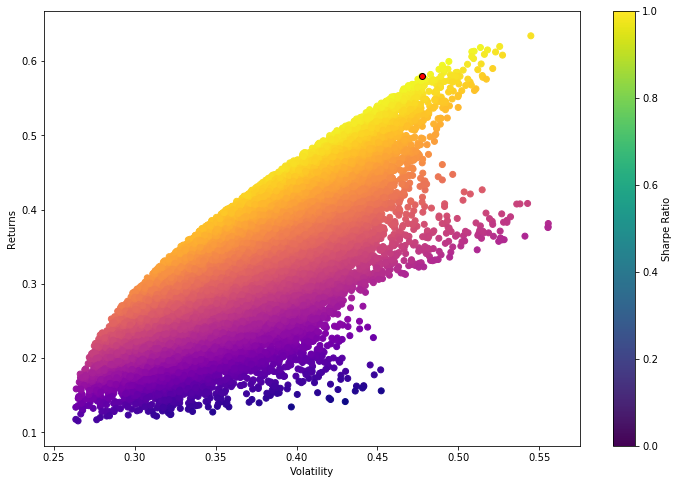

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(volatility_arr, return_arr, c = sharpe_ratio_arr, cmap = 'plasma')
plt.scatter(volatility_max, return_max, c = 'red', edgecolors='black')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')

In [0]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum((Adj_close_log.mean() * weights) * 252)
    vol = np.sqrt(np.dot(weights.T,np.dot(Adj_close_log.cov() * 252, weights)))
    sr = ret / vol
    
    return np.array([ret, vol, sr])

In [0]:
def neg_sr(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [0]:
bounds = ((0,1),(0,1),(0,1),(0,1))

In [0]:
def check_sum(weights):
    return np.sum(weights) - 1

In [0]:
cons = ({'type' : 'eq' , 'fun' : check_sum}) 

In [0]:
init_guess = [0.25,0.25,0.25,0.25]

In [0]:
optimal_result = minimize(neg_sr, init_guess, method = 'SLSQP', bounds= bounds, constraints= cons)

In [0]:
optimal_result

     fun: -1.2190290532842247
     jac: array([ 1.96546316e-05,  4.22083512e-01, -5.82784414e-05,  9.80439633e-02])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([7.47845424e-01, 2.46439154e-16, 2.52154576e-01, 0.00000000e+00])

In [0]:
optimal_result.x

array([7.47845424e-01, 2.46439154e-16, 2.52154576e-01, 0.00000000e+00])

In [0]:
get_ret_vol_sr([7.47845424e-01, 2.46439154e-16, 2.52154576e-01, 0.00000000e+00])

array([0.60048013, 0.49258886, 1.21902905])

In [0]:
frontier_y = np.linspace(0.12, 0.65, 200)

In [0]:
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

In [0]:
frontier_volatility = []

for possible_return in frontier_y:
    const = ({'type' : 'eq', 'fun' : check_sum},
            {'type' : 'eq' , 'fun' : lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_vol, init_guess, method = 'SLSQP', bounds= bounds, constraints= const)
    frontier_volatility.append(result['fun'])

Text(0, 0.5, 'Returns')

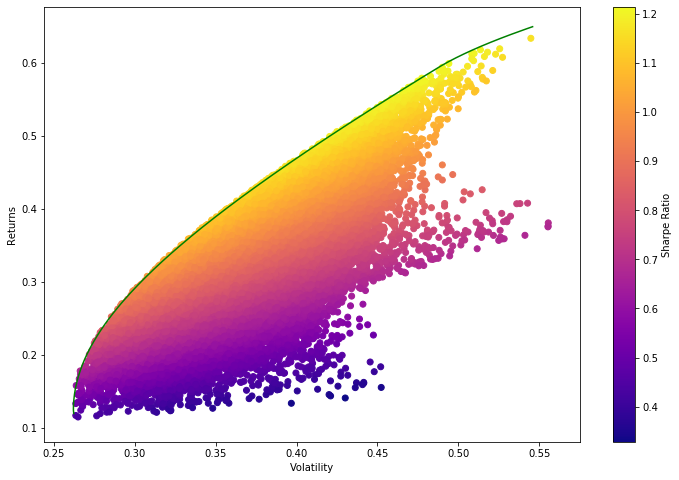

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(volatility_arr, return_arr, c = sharpe_ratio_arr, cmap = 'plasma')
plt.plot(frontier_volatility, frontier_y, 'g-')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')